<a href="https://colab.research.google.com/github/jduda01/hgf_py/blob/main/JD_Example_3_Multi_armed_bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(example_3)=
# Example 3: A multi-armed bandit task with independent rewards and punishments

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_2_Input_node_volatility_coupling.ipynb)

In [ ]:
import sys
from IPython.utils import io
if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [ ]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from jax import jit, vjp
from jax.tree_util import Partial
from pyhgf.math import binary_surprise
from pyhgf.model import Network
from pyhgf.utils import beliefs_propagation
from pytensor.graph import Apply, Op

np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

In [ ]:
# the tonic volatility used across the tutorial
# this value is the same for four branches of the network
tonic_volatility = -1.5

In [ ]:
!pwd
import pandas as pd
mask = pd.read_csv('mask.csv').to_numpy()
u = pd.read_csv('u.csv').to_numpy()

/content


We start by creating a network that consists in four two-levels HGF. Each branch is evolving independently and is not affecting the beliefs trajectories of other branches.

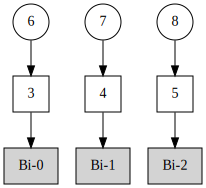

In [ ]:
tonic_volatility = -.6

three_armed_bandit_hgf = (
    Network()
    .add_nodes(kind="binary-input", n_nodes=3)
    .add_nodes(kind="binary-state", value_children=0)
    .add_nodes(kind="binary-state", value_children=1)
    .add_nodes(kind="binary-state", value_children=2)
    .add_nodes(value_children=3, tonic_volatility=tonic_volatility)
    .add_nodes(value_children=4, tonic_volatility=tonic_volatility)
    .add_nodes(value_children=5, tonic_volatility=tonic_volatility)
)
three_armed_bandit_hgf.plot_network()

In [ ]:
# note that we are providing the mask as parameter of the input function
three_armed_bandit_hgf.input_data(
    input_data=u,
    observed=mask,
);

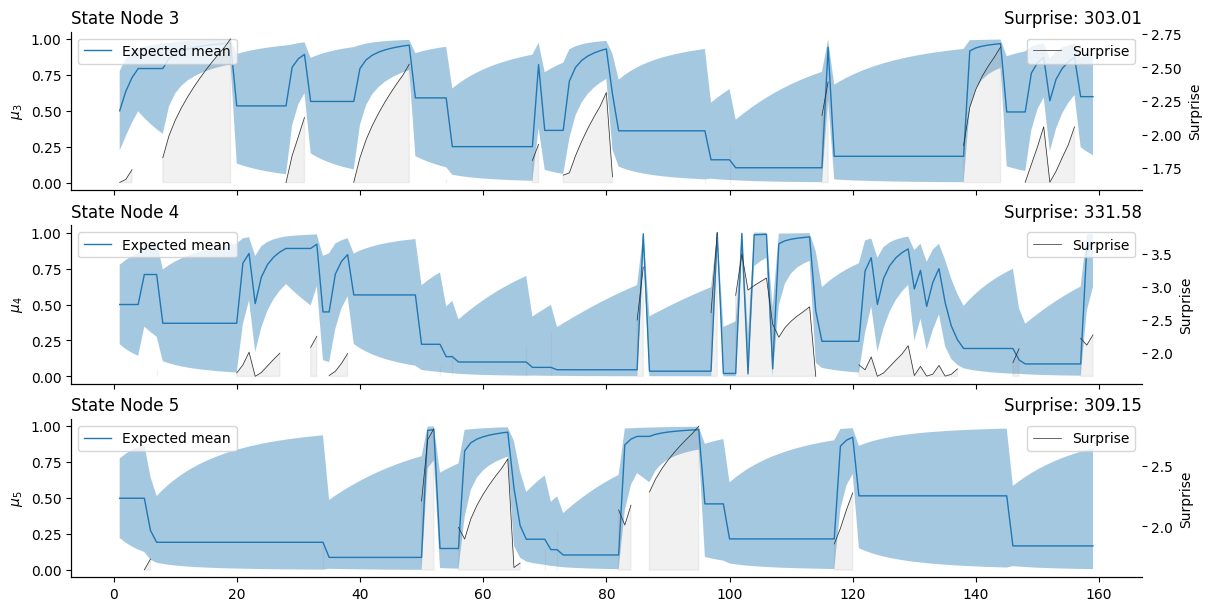

In [ ]:
_, axs = plt.subplots(figsize=(12, 6), nrows=3, sharex=True, sharey=True)

three_armed_bandit_hgf.plot_nodes(node_idxs=3, axs=axs[0])
three_armed_bandit_hgf.plot_nodes(node_idxs=4, axs=axs[1])
three_armed_bandit_hgf.plot_nodes(node_idxs=5, axs=axs[2])
sns.despine();

### Decision rule

The probability of chosing the arm $A$ given the expected probabilities of wining on both arms ${W_a; W_b}$ and the expected probabilities of loosing on both arms ${L_a; L_b}$, is given by the following softmax decision function:

$$
p(A) = \frac{e^{\beta(W_a-L_a)}}{e^{\beta(W_a-L_a)} + e^{\beta(W_b-L_b)}}
$$

where $\beta$ is the inverse temperature parameter.

In [ ]:
beta = 1.0  # temperature parameter
x_3 = three_armed_bandit_hgf.node_trajectories[3]["expected_mean"]
x_4 = three_armed_bandit_hgf.node_trajectories[4]["expected_mean"]
x_5 = three_armed_bandit_hgf.node_trajectories[5]["expected_mean"]

p_1 = np.exp(beta * x_3) / (
    np.exp(beta * x_3) + np.exp(beta * x_4) + np.exp(beta * x_5)
)

p_2 = np.exp(beta * x_4) / (
    np.exp(beta * x_3) + np.exp(beta * x_4) + np.exp(beta * x_5)
)

p_3 = np.exp(beta * x_5) / (
    np.exp(beta * x_3) + np.exp(beta * x_4) + np.exp(beta * x_5)
)

In [ ]:
from pyhgf.math import binary_surprise

In [ ]:
(
    binary_surprise(x=mask[:, 0], expected_mean=p_1).sum() +
    binary_surprise(x=mask[:, 1], expected_mean=p_2).sum() +
    binary_surprise(x=mask[:, 2], expected_mean=p_3).sum()
)

Array(288.2765, dtype=float32)

In [ ]:
def three_bandits_logp(tonic_volatility, hgf, input_data, responses, observed):

    # replace with a new omega in the model
    hgf.attributes[6]["tonic_volatility"] = tonic_volatility
    hgf.attributes[7]["tonic_volatility"] = tonic_volatility
    hgf.attributes[8]["tonic_volatility"] = tonic_volatility

    # run the model forward
    hgf.input_data(input_data=input_data, observed=observed)

    beta = 1.0  # temperature parameter
    x_3 = hgf.node_trajectories[3]["expected_mean"]
    x_4 = hgf.node_trajectories[4]["expected_mean"]
    x_5 = hgf.node_trajectories[5]["expected_mean"]

    p_1 = jnp.exp(beta * x_3) / (
        jnp.exp(beta * x_3) + jnp.exp(beta * x_4) + jnp.exp(beta * x_5)
    )

    p_2 = jnp.exp(beta * x_4) / (
        jnp.exp(beta * x_3) + jnp.exp(beta * x_4) + jnp.exp(beta * x_5)
    )

    p_3 = jnp.exp(beta * x_5) / (
        jnp.exp(beta * x_3) + jnp.exp(beta * x_4) + jnp.exp(beta * x_5)
    )


    # binary surprise given this probability
    surprise = (
      binary_surprise(x=mask[:, 0], expected_mean=p_1).sum() +
      binary_surprise(x=mask[:, 1], expected_mean=p_2).sum() +
      binary_surprise(x=mask[:, 2], expected_mean=p_3).sum()
  )
    surprise = jnp.where(jnp.isnan(surprise), jnp.inf, surprise)

    return -surprise

In [ ]:
three_bandits_logp(
    tonic_volatility=-2.0,
    hgf=three_armed_bandit_hgf,
    input_data=u,
    responses=mask,
    observed=mask,
)

Array(-268.68744, dtype=float32)

```{hint}
The response function computes the sum of the binary surprise (see {py:func}`pyhgf.math.binary_surprise`) at the first level of the four binary HGFs, and adds the binary surprise for the observed decision given the probabilities predicted by the sigmoid decision rule. While we are mostly interested in predicting the latter (and could use solely this quantity for optimization), this can produce situations where the binary HGFs are forced toward *extreme* beliefs in a way that overfit the responses from the participant. Adding their surprise in the equation ensures that these situations are limited, as such trajectories are also associated with extreme surprise. As always, we return the negative surprise to get a log probability that can be manipulated by PyMC.
```

We create both a jitted version of this function and the vector-jacobian product (gradient) requiered for a custom Op in PyTensor:

In [ ]:
logp_fn = Partial(
    three_bandits_logp,
    hgf=three_armed_bandit_hgf,
    input_data=u,
    responses=mask,
    observed=mask,
)

In [ ]:
jitted_custom_op_jax(-2.0)

Array(-268.68744, dtype=float32)

In [ ]:
jitted_custom_op_jax = jit(logp_fn)

def vjp_custom_op_jax(x, gz):
    _, vjp_fn = vjp(logp_fn, x)
    return vjp_fn(gz)[0]

jitted_vjp_custom_op_jax = jit(vjp_custom_op_jax)

The log probability function and the gradient of this function are then passed to a new `Op`, which is a class that can be manipulated inside PyMC graphs.

In [ ]:
# The CustomOp needs `make_node`, `perform` and `grad`.
class CustomOp(Op):
    def make_node(self, x):
        # Create a PyTensor node specifying the number and type of inputs and outputs

        # We convert the input into a PyTensor tensor variable
        inputs = [pt.as_tensor_variable(x)]
        # Output has the same type and shape as `x`
        outputs = [inputs[0].type()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        # Evaluate the Op result for a specific numerical input

        # The inputs are always wrapped in a list
        (x,) = inputs
        result = jitted_custom_op_jax(x)
        # The results should be assigned in place to the nested list
        # of outputs provided by PyTensor. If you have multiple
        # outputs and results, you should assign each at outputs[i][0]
        outputs[0][0] = np.asarray(result, dtype="float64")

    def grad(self, inputs, output_gradients):
        # Create a PyTensor expression of the gradient
        (x,) = inputs
        (gz,) = output_gradients
        # We reference the VJP Op created below, which encapsulates
        # the gradient operation
        return [vjp_custom_op(x, gz)]


class VJPCustomOp(Op):
    def make_node(self, x, gz):
        # Make sure the two inputs are tensor variables
        inputs = [pt.as_tensor_variable(x), pt.as_tensor_variable(gz)]
        # Output has the shape type and shape as the first input
        outputs = [inputs[0].type()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (x, gz) = inputs
        result = jitted_vjp_custom_op_jax(x, gz)
        outputs[0][0] = np.asarray(result, dtype="float64")


# Instantiate the Ops
custom_op = CustomOp()
vjp_custom_op = VJPCustomOp()

We are now ready to sample the model and estimate the value of tonic volatility.

In [ ]:
with pm.Model() as model:
    omega = pm.Normal("omega", -4.0, 5)
    pm.Potential("hgf", custom_op(omega))
    idata = pm.sample(chains=2, cores=1)

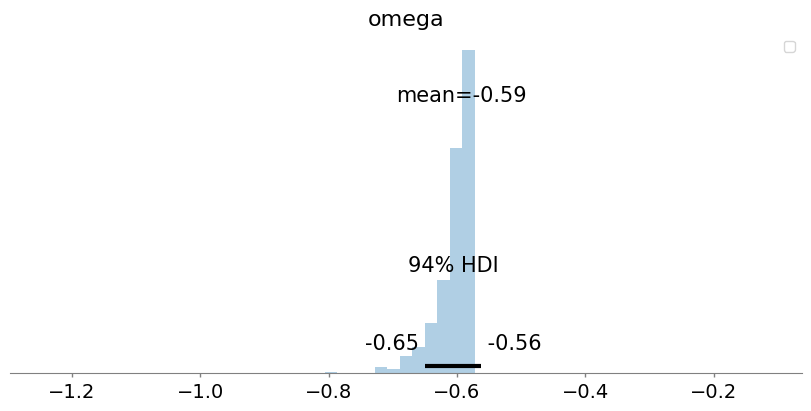

In [ ]:
_, ax = plt.subplots(figsize=(8, 4))
az.plot_posterior(idata, ax=ax, kind="hist")
plt.legend();

## System configuration

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Fri Aug 23 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.23.0

pyhgf : 0.1.4
jax   : 0.4.31
jaxlib: 0.4.31

pytensor  : 2.25.2
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
seaborn   : 0.13.2
pymc      : 5.16.2
arviz     : 0.19.0
matplotlib: 3.8.4
jax       : 0.4.31
numpy     : 1.26.0

Watermark: 2.4.3

